In [33]:
%load_ext blackcellmagic
%matplotlib inline


import pandas as pd
import requests
import re
import ast
import numpy as np
import seaborn as sns

from collections import defaultdict

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [34]:
ccc_df = pd.read_csv("ccc_blm.csv")
ele_df = pd.read_csv("ele.csv")
cl_df = pd.read_csv("cl_blm.csv")

dfs = [ccc_df, ele_df, cl_df]

In [35]:
df = pd.concat(dfs).reset_index(drop=True)
len(df)

3892

In [36]:
# fix stay commas

df['city_st'] = df['city_st'].str.replace(' , ', ', ')
df['city_st'] = df['city_st'].str.strip()


len(df)

3892

In [37]:
# eliminate non US events

countries = [
    "Finland",
    "England",
    "Wales",
    "Canada",
    "Scotland",
    "Germany",
    "Ireland", 'Sweden'
    "Netherlands",
    "New Zealand",
    "Denmark",
    "Australia",
    "Belgium",
    "France", 'Hungary',
]


def in_us(city_st):
    for c in countries:
        c2 = ", " + c
        if c2 in city_st:
            return False

    return True


df = df[df["city_st"].apply(in_us)].copy()
len(df)

3851

In [38]:
errors = {'Albuqeurque, NM' : 'Albuquerque, NM',
         'Bilings, MT' : 'Billings, MT',
         'Breckinridge, CO' : 'Breckinridge, CO',
          "Longbranch, NJ" : "Long Branch, NJ",
          'Lousiville, KY' : 'Louisville, KY',
          'Merrick, New York' : 'Merrick, NY',
          'Pittsfield Charter Township, MI' : 'Pittsfield, MI',
          'Pittsfield Township, MI' : 'Pittsfield, MI',
          'Phillipsburg, PA' : 'Philipsburg, PA',
          'South Sacramento, CA' :  'Sacramento, CA',
          'Shelbourne Falls, MA' : 'Shelburne Falls, MA',
          'Tallahasee, FL' : 'Tallahassee, FL',
          'Tampa Bay, FL' : "Tampa, Fl",
          'Voorhees Township, NJ' : 'Voorhees, NJ',
          'Warren Township, NJ' : 'Warren, NJ', 
          'Summerlin, NV' : 'Las Vegas, NV',
          'Stockton, TX' : 'Fort Stockton, TX',
          'Standford, CA' : 'Stanford, CA',
        
          
         }

for city in errors:
    df['city_st'] = df['city_st'].str.replace(city, errors[city])

In [39]:
#uniform saint to st
df['city_st'] = df['city_st'].str.replace('Saint ', 'St. ')

In [40]:
df['urls'] == "['https://kfor.com/news/local/protester-hit-by-vehicle-during-protest-in-tulsa-over-george-floyds-death/']'"

0       False
1       False
2       False
3       False
4       False
        ...  
3887    False
3888    False
3889    False
3890    False
3891    False
Name: urls, Length: 3851, dtype: bool

In [41]:
df['events'] = 1
df['size'] = df['size'].replace(0,np.nan)
df['size_imp'] = df['size'].fillna(11)


df = pd.concat([df, pd.get_dummies(df['collection'])], axis=1)

In [42]:
# extract urls to make them variables

def str_2_list(links):
    return ast.literal_eval(links)

df['url_list'] = df['urls'].apply(str_2_list)


urls = set([item for sublist in df['url_list'].values for item in sublist])

for url in urls:
    df[url] = df['urls'].str.contains(url)

First Pass at Aggregation

In [43]:
# first sum by collection for multiple events by city
df_cd = df.groupby(['collection', 'date', 'city_st']).sum().reset_index()

In [44]:
df_cd['size_imp'] = df_cd['size'].fillna(11)



In [45]:
for v in ["CCC", 
    "Count Love", 
    "Elephrame"]:
    df_cd[v] = df_cd[v] > 0
    df_cd[v] = df_cd[v].astype(int)

In [46]:

aggregation = {
    "events": "max",
    "size": "max",
    "size_imp" : "max",
    "CCC" : "max",
    "Count Love" : "max",
    "Elephrame" : "max"
}


for url in urls:
    aggregation[url] = 'max'

df_cd = df_cd.groupby(["date", "city_st"]).agg(aggregation).reset_index()

In [47]:
# Create list of URLs

index_dict = defaultdict(list)

http_urls = [u for u in df_cd.keys() if 'http' in u]

for url in http_urls:
    for i in df_cd[df_cd[url] == True].index.values:
        index_dict[i].append(url)

url_df = pd.Series(index_dict).to_frame(name='urls')



In [48]:
keep = [
    "date",
    "city_st",
    "events",
    "size",
    "size_imp",
    "CCC",
    "Count Love",
    "Elephrame",

]

In [49]:
df_cd = df_cd[keep].merge(url_df, left_index=True, right_index=True)

In [50]:
df_cd['size'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].replace(0, np.nan)
df_cd['size_imp'] = df_cd['size'].fillna(11)

In [51]:
date_start = pd.to_datetime('2020-05-24')
df_cd = df_cd[pd.to_datetime(df_cd['date']) >= date_start].copy()



In [52]:


df_cd.to_csv('../BLM-GFAABT.csv', index =False)




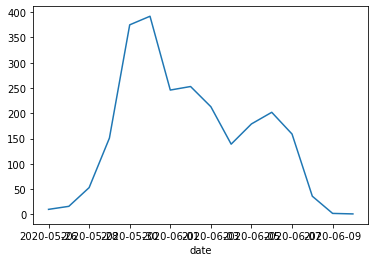

In [57]:
df_cd.groupby('date')['events'].sum().plot();

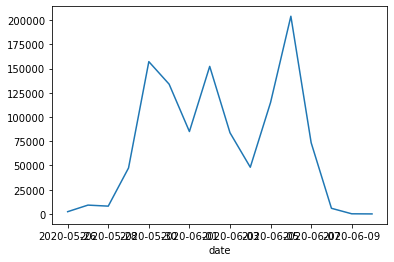

In [53]:
df_cd.groupby('date')['size_imp'].sum().plot();

In [54]:
df_cd['size_imp'].sum()

1125864.5

In [55]:
df_cd['size'].sum()

1118087.5

In [56]:
df_cd.groupby(["CCC", "Count Love", 'Elephrame'])['events'].count().reset_index()

,CCC,Count Love,Elephrame,events
0,0,0,1,236
1,0,1,0,781
2,0,1,1,103
3,1,0,0,508
4,1,0,1,50
5,1,1,0,312
6,1,1,1,141
